In [1]:
import cv2 as cv
import numpy as np
from util_func import *

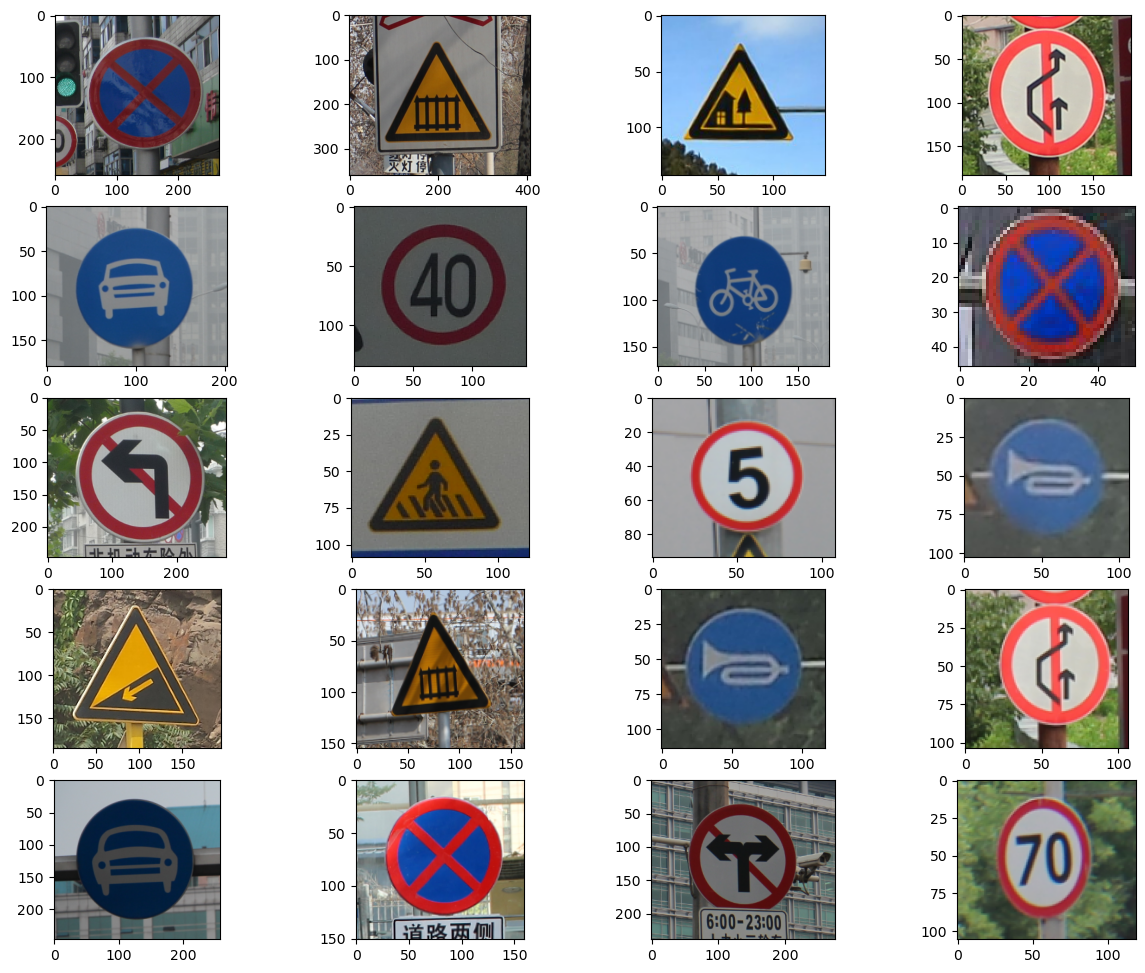

In [2]:
import matplotlib.pyplot as plt
import os

files = np.random.choice(os.listdir("tsrd-train/"), size=20, replace=False)
img_dir = "tsrd-train/"

plt.figure(figsize=(15, 12))
for i, img_file in enumerate(files):
    img = cv.imread(img_dir + img_file)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)
    
plt.show()

In [3]:
import pandas as pd

annotations = pd.read_csv("TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt", 
                          sep=";", header=None)
annotations.head()

0    1    2   3   4    5    6  7   8
0  000_0001.png  134  128  19   7  120  117  0 NaN
1  000_0002.png  165  151  23  12  149  138  0 NaN
2  000_0003.png  128  122  22  14  116  105  0 NaN
3  000_0010.png   80   73  14   8   67   63  0 NaN
4  000_0011.png  186  174  36  15  155  157  0 NaN

In [4]:
img = cv.imread("tsrd-train//000_0011.png")
img.shape

(174, 186, 3)

In [5]:
img = cv.imread("tsrd-train//000_0011.png")
img.shape[0]

174

In [6]:
annotations.drop([8], axis=1, inplace=True)

In [7]:
annotations.columns = ["filenames", "width", "height", "x_start", "y_start", "x_end", "y_end", "labels"]
annotations.head()

filenames  width  height  x_start  y_start  x_end  y_end  labels
0  000_0001.png    134     128       19        7    120    117       0
1  000_0002.png    165     151       23       12    149    138       0
2  000_0003.png    128     122       22       14    116    105       0
3  000_0010.png     80      73       14        8     67     63       0
4  000_0011.png    186     174       36       15    155    157       0

In [8]:
annotations.set_index("filenames", inplace=True)
annotations.head()

width  height  x_start  y_start  x_end  y_end  labels
filenames                                                          
000_0001.png    134     128       19        7    120    117       0
000_0002.png    165     151       23       12    149    138       0
000_0003.png    128     122       22       14    116    105       0
000_0010.png     80      73       14        8     67     63       0
000_0011.png    186     174       36       15    155    157       0

In [9]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4170 entries, 000_0001.png to 056_1_0054.png
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   width    4170 non-null   int64
 1   height   4170 non-null   int64
 2   x_start  4170 non-null   int64
 3   y_start  4170 non-null   int64
 4   x_end    4170 non-null   int64
 5   y_end    4170 non-null   int64
 6   labels   4170 non-null   int64
dtypes: int64(7)
memory usage: 260.6+ KB


---
### Define Image Processing Functions and Accuracy Measures

In [10]:
def contrast_enhance(img):
    img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
    L, a, b = cv.split(img_lab)
    L = cv.equalizeHist(L)
    img_lab_merge = cv.merge((L, a, b))
    return cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)

In [11]:
# canny edge detection
def auto_canny(img, method, sigma=0.33):
    """
    Args:
    img: grayscale image
    method: Otsu, triangle, and median
    sigma: 0.33 (default)
    2 outputs:
    edge_detection output, the high threshold"""
    if method=="median":
        Th = np.median(img)
        
    elif method=="triangle":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)
        
    elif method=="otsu":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_OTSU)
        
    else:
        raise Exception("method specified not available!")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh), highTh

In [12]:
# Color based segmentation
# Color based segmentation (red, blue, yellow, black)
# Red color
lower_red1 = (0, 40, 50)
upper_red1 = (10, 255, 210)
lower_red2 = (165, 40, 50)
upper_red2 = (179, 255, 210)

# Blue color 
lower_blue = (90, 40, 50)
upper_blue = (120, 255, 210)

# Yellow colors
lower_yellow = (20, 40, 50)
upper_yellow = (35, 255, 210)

# black colors
lower_black = (0, 0, 0)
upper_black = (179, 255, 5)

def color_seg(img, kernel_size=None):
    """Args:
    img: image in bgr
    kernel_size: None (default:(3, 3))"""
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    mask_red1 = cv.inRange(hsv_img, lower_red1, upper_red1)
    mask_red2 = cv.inRange(hsv_img, lower_red2, upper_red2)
    mask_blue = cv.inRange(hsv_img, lower_blue, upper_blue)
    mask_yellow = cv.inRange(hsv_img, lower_yellow, upper_yellow)
    mask_black = cv.inRange(hsv_img, lower_black, upper_black)
    
    mask_combined = mask_red1 | mask_red2 | mask_blue | mask_yellow | mask_black
    
    if kernel_size is not None:
        kernel = np.ones(kernel_size, np.uint8)
    else:
        kernel = np.ones((3, 3), np.uint8)
        
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_OPEN, kernel)
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_CLOSE, kernel)
    
    return mask_combined

In [13]:
# rectangle detection (using Douglas-Peuker algorithm)
def cnt_rect(cnts, coef=0.1):
    contour_list = []
    for cnt in cnts:
        peri = cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, coef*peri, True)
        if len(approx) == 4:
            contour_list.append(cnt)

    if not contour_list:
        return None
    else:
        LC = max(contour_list, key=cv.contourArea)
        return LC
    
# circle detection
hough_circle_parameters = {
    "dp": 1,
    "minDist": 150,
    "param1": 200,    # adaptively change according to image
    "param2": 15,  
    "minRadius": 10,
    "maxRadius": 100
}
def cnt_circle(img, hough_dict):
    """Args:
    img: Grayscale Image after resizing
    cnt: contour
    hough_dict: hough_circle_transform parameters"""
    mask = np.zeros_like(img)
    circles = cv.HoughCircles(img, 
                              cv.HOUGH_GRADIENT, 
                              hough_dict["dp"], 
                              hough_dict["minDist"], 
                              param1=hough_dict["param1"], 
                              param2=hough_dict["param2"],
                              minRadius=hough_dict["minRadius"], 
                              maxRadius=hough_dict["maxRadius"])
    if circles is None:
        return circles
    else:
        # perform LCA
        list_circles = circles[0]
        largest_circles = max(list_circles, key=lambda x: x[2])
        center_x, center_y, r = largest_circles
        cv.circle(mask, (int(center_x), int(center_y)), int(r), 255)
        cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cnt = cnts[0]
        if len(cnts[0])>0:
            return max(cnt, key=cv.contourArea)
        else:
            return cnt[-1]

def cnt_triangle(cnts, coef=0.1):
    contour_list = []
    for cnt in cnts:
        peri = cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, coef * peri, True)
        if len(approx) == 3:  # Check if the approximated contour has 3 vertices
            contour_list.append(cnt)

    if not contour_list:
        return None
    else:
        LC = max(contour_list, key=cv.contourArea)  # Return the largest triangle
        return LC

In [14]:
# combine the results of 2 shape detectors
def integrate_circle_rect(rect_cnt, circle_cnt, cnt):
    if circle_cnt is not None and rect_cnt is not None:
        # compare the area
        if cv.contourArea(circle_cnt) >= cv.contourArea(rect_cnt):
            output = circle_cnt
        else:
            output = rect_cnt

    elif circle_cnt is not None and rect_cnt is None:
        output = circle_cnt

    elif circle_cnt is None and rect_cnt is not None:
        output = rect_cnt

    else:
        if len(cnt)==0:
            return np.array([])
        else:
            output = max(cnt, key=cv.contourArea)

    return output

In [15]:
# combine the results of 3 shape detectors
def integrate_circle_rect_triangle(rect_cnt, circle_cnt, triangle_cnt, cnt):
    if circle_cnt is not None and rect_cnt is not None and triangle_cnt is not None:
        # Compare the areas
        areas = [cv.contourArea(circle_cnt), cv.contourArea(rect_cnt), cv.contourArea(triangle_cnt)]
        max_area_index = areas.index(max(areas))
        if max_area_index == 0:
            output = circle_cnt
        elif max_area_index == 1:
            output = rect_cnt
        else:
            output = triangle_cnt

    elif circle_cnt is not None and rect_cnt is None and triangle_cnt is None:
        output = circle_cnt

    elif circle_cnt is None and rect_cnt is not None and triangle_cnt is None:
        output = rect_cnt

    elif circle_cnt is None and rect_cnt is None and triangle_cnt is not None:
        output = triangle_cnt

    elif circle_cnt is not None and rect_cnt is not None and triangle_cnt is None:
        if cv.contourArea(circle_cnt) >= cv.contourArea(rect_cnt):
            output = circle_cnt
        else:
            output = rect_cnt

    elif circle_cnt is not None and rect_cnt is None and triangle_cnt is not None:
        if cv.contourArea(circle_cnt) >= cv.contourArea(triangle_cnt):
            output = circle_cnt
        else:
            output = triangle_cnt

    elif circle_cnt is None and rect_cnt is not None and triangle_cnt is not None:
        if cv.contourArea(rect_cnt) >= cv.contourArea(triangle_cnt):
            output = rect_cnt
        else:
            output = triangle_cnt

    else:
        if len(cnt) == 0:
            return np.array([])
        else:
            output = max(cnt, key=cv.contourArea)

    return output

In [16]:
# combine the results of edge detector + color based segmentation followed by shape detection combined results
def integrate_edge_color(output1, output2):
    if not isinstance(output1, np.ndarray):
        output1 = np.array(output1)
        
    if not isinstance(output2, np.ndarray):
        output2 = np.array(output2)
        
    if len(output1)==0 and len(output2)==0:
        return np.array([])
    
    elif len(output1)==0 and output2.shape[-1]==2:
        return output2
    
    elif len(output2)==0 and output1.shape[-1]==2:
        return output1
    
    else:
        if cv.contourArea(output1[0]) > cv.contourArea(output2[0]):
            return output1
        else:
            return output2

In [17]:
def integrate_edges_colors(output1, output2, output3):
    if not isinstance(output1, np.ndarray):
        output1 = np.array(output1)
        
    if not isinstance(output2, np.ndarray):
        output2 = np.array(output2)

    if not isinstance(output3, np.ndarray):
        output3 = np.array(output3)

    if len(output1) == 0 and len(output2) == 0 and len(output3) == 0:
        return np.array([])

    elif len(output1) == 0 and output2.shape[-1] == 2 and output3.shape[-1] == 2:
        return output2 if cv.contourArea(output2[0]) >= cv.contourArea(output3[0]) else output3

    elif len(output2) == 0 and output1.shape[-1] == 2 and output3.shape[-1] == 2:
        return output1 if cv.contourArea(output1[0]) >= cv.contourArea(output3[0]) else output3

    elif len(output3) == 0 and output1.shape[-1] == 2 and output2.shape[-1] == 2:
        return output1 if cv.contourArea(output1[0]) >= cv.contourArea(output2[0]) else output2

    else:
        areas = [cv.contourArea(output1[0]), cv.contourArea(output2[0]), cv.contourArea(output3[0])]
        max_area_index = areas.index(max(areas))
        if max_area_index == 0:
            return output1
        elif max_area_index == 1:
            return output2
        else:
            return output3

---
#### IOU Measure

Intersection over Union (IOU) is a metric used to evaluate the accuracy of an object detection algorithm. It measures the overlap between the predicted bounding box and the ground truth bounding box. The IOU is calculated using the following formula:

$$\text{IOU} = \frac{\text{Area of Overlap}}
{\text{Area of Union}}
$$

Explanation:
  * Area of Overlap: This is the area where the predicted bounding box and the ground truth bounding box overlap.
  * Area of Union: This is the total area covered by both the predicted and ground truth bounding boxes combined.

Calculation Steps:
1. Determine the coordinates of both the predicted and ground truth bounding boxes.
2. Calculate the area of overlap by finding the intersection of the two boxes.
3. Calculate the area of union by combining the areas of both boxes and subtracting the area of overlap.
4. Compute the IOU using the formula above.

Interpretation:
   * An IOU of 1 indicates perfect overlap, meaning the predicted box perfectly matches the ground truth box.
   * An IOU of 0 indicates no overlap at all.
   * Typically, an IOU threshold (e.g., 0.5) is used to determine whether a detection is considered a true positive.
This metric is widely used in computer vision tasks, particularly in object detection and segmentation, to assess the performance of models.

> **IOU of 0:** This signifies that the predicted area does not intersect with the actual area of the traffic sign at all. Therefore, the segmentation is not accurate, and the traffic sign is not correctly identified.

> **Correct Segmentation:** For a segmentation to be considered correct, the IOU should be above a certain threshold: 
$$IOU ≥ 0.5$$ (commonly 0.5 or higher, depending on the application).
 
> An IOU of 0 suggests that the model failed to detect the traffic sign or that the prediction is entirely misplaced.

In [18]:
# Calculate the IoU between two bounding boxes
def computeIOU(boxA, boxB):
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

#### Evaluation Metrics
In addition to Intersection over Union (IOU), several other algorithms and metrics can be used to evaluate the quality of segmentation in image processing tasks, including traffic sign segmentation. Here are some commonly used alternatives:

1. Pixel Accuracy

    * Definition: This metric calculates the ratio of correctly classified pixels to the total number of pixels in the image.
    * Formula:
$$\text{Pixel Accuracy} = \frac{\text{Number of Correct Pixels}}
{\text{Total Number of Pixels}}
$$
```
```
2. Dice Coefficient (F1 Score)

    * Definition: The Dice coefficient measures the similarity between two sets. It is particularly useful in medical imaging and binary segmentation tasks.    
    * Formula:
$$\text{Dice Coefficient} = \frac{\text{2 × |𝐴 ∩ 𝐵|}}
{\text{|𝐴| + |𝐵|}}
$$

> where 𝐴 is the predicted segmentation and 𝐵 is the ground truth.
```
```
3. Precision and Recall

    * Precision: Measures the accuracy of the positive predictions.
    $$\text{Precision} = \frac{\text{𝑇𝑃}}{\text{𝑇𝑃 + 𝐹𝑃}}$$
    ```
    ```
    * Recall: Measures the ability of the model to find all the relevant cases (true positives).
    $$\text{Recall} =\frac{\text{𝑇𝑃}}{\text{𝑇𝑃 + 𝐹𝑁}}$$
    ```
    ```
    * F1 Score: The harmonic mean of precision and recall, providing a single score to evaluate the model's performance.
```
```
4. Boundary Precision and Recall

    * Definition: These metrics evaluate how well the predicted boundaries of the segmentation match the ground truth boundaries, focusing on the edges of the segmented regions.
```
```
5. Mean Absolute Error (MAE)

    * Definition: This metric calculates the average of the absolute differences between the predicted segmentation and the ground truth segmentation.
```
```
6. Jaccard Index

    * Definition: Similar to IOU, the Jaccard index measures the size of the intersection divided by the size of the union of two sets.   
    * Formula:
$$\text{Jaccard Index} = \frac{\text{∣𝐴 ∩ 𝐵∣}}
{\text{∣𝐴 ∪ 𝐵∣}}
$$
$$\$$

7. Hausdorff Distance

    * Definition: This metric measures the maximum distance from a point in one set to the nearest point in the other set, providing a measure of the segmentation's worst-case error.
```
```
8. Structural Similarity Index (SSIM)

    * Definition: SSIM is used to measure the similarity between two images, focusing on changes in structural information, luminance, and contrast.    

$$\$$
Conclusion

While IOU is a widely used metric for evaluating segmentation quality, these alternatives provide additional perspectives on the performance of segmentation algorithms. Depending on the specific requirements of your application, you may choose one or more of these metrics to gain a comprehensive understanding of segmentation quality.


---

In [19]:
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import directed_hausdorff

def pixel_accuracy(predicted, ground_truth):
    correct_pixels = np.sum(predicted == ground_truth)
    total_pixels = ground_truth.size
    return correct_pixels / total_pixels

def dice_coefficient(predicted, ground_truth):
    intersection = np.sum(predicted * ground_truth)
    return (2. * intersection) / (np.sum(predicted) + np.sum(ground_truth))

def precision_recall(predicted, ground_truth):
    TP = np.sum(predicted * ground_truth)
    FP = np.sum(predicted) - TP
    FN = np.sum(ground_truth) - TP
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

def mean_absolute_error(predicted, ground_truth):
    return np.mean(np.abs(predicted - ground_truth))

def jaccard_index(predicted, ground_truth):
    intersection = np.sum(predicted * ground_truth)
    union = np.sum(predicted) + np.sum(ground_truth) - intersection
    return intersection / union if union > 0 else 0

def hausdorff_distance(predicted, ground_truth):
    pred_coords = np.argwhere(predicted)
    gt_coords = np.argwhere(ground_truth)
    
    if len(pred_coords) == 0 or len(gt_coords) == 0:
        return float('inf')  # If one of the sets is empty
    
    d1 = directed_hausdorff(pred_coords, gt_coords)[0]
    d2 = directed_hausdorff(gt_coords, pred_coords)[0]
    
    return max(d1, d2)

def compute_ssim(predicted, ground_truth):
    # Ensure both images are in the same format (single channel or 3 channels)
    if predicted.ndim == 3 and predicted.shape[2] == 3:
        predicted = cv.cvtColor(predicted, cv.COLOR_BGR2GRAY)
        
    if ground_truth.ndim == 3 and ground_truth.shape[2] == 3:
        ground_truth = cv.cvtColor(ground_truth, cv.COLOR_BGR2GRAY)

    # Calculate SSIM
    return ssim(predicted, ground_truth, data_range=predicted.max() - predicted.min())

---
### Testing the defined functions:

#### Contrast Enhancement

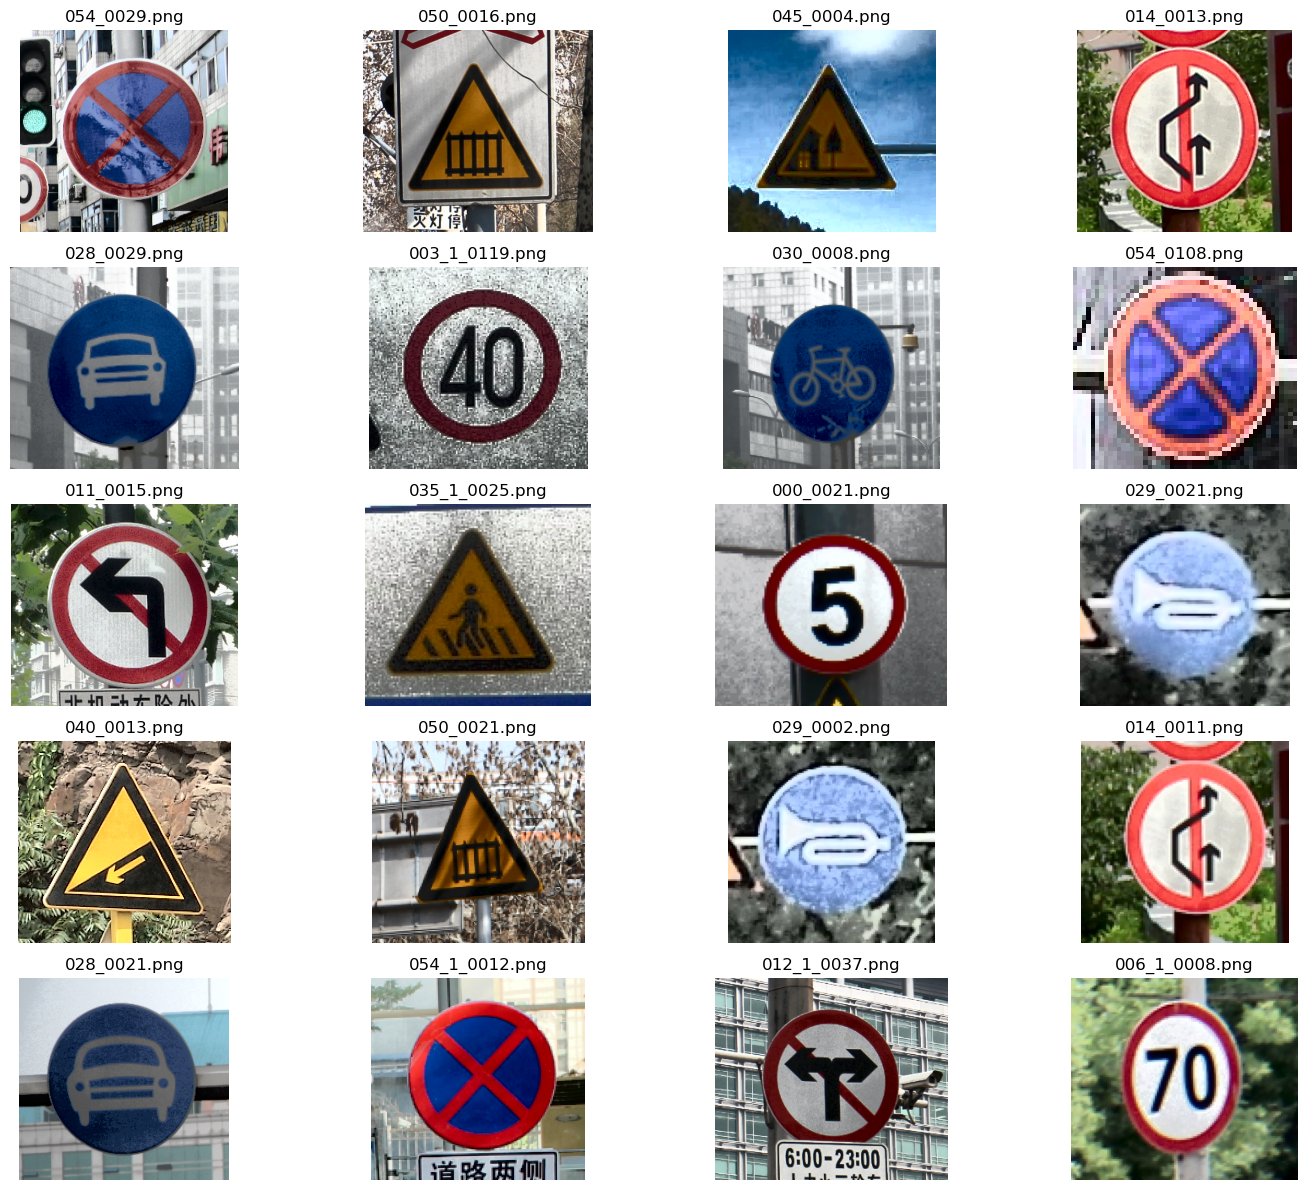

In [20]:
plt.figure(figsize=(15, 12))
for i, img_file in enumerate(files):
    try:
        img = cv.imread(img_dir + img_file)
        if img is None:
            raise ValueError(f"Image {img_file} could not be read.")
        img_enhanced = contrast_enhance(img)
        img_rgb = cv.cvtColor(img_enhanced, cv.COLOR_BGR2RGB)
        
        plt.subplot(5, 4, i+1)
        plt.imshow(img_rgb)
        plt.title(img_file)
        plt.axis('off')
    except Exception as e:
        print(e)

plt.tight_layout()
plt.show()

#### Canny Edge Detection

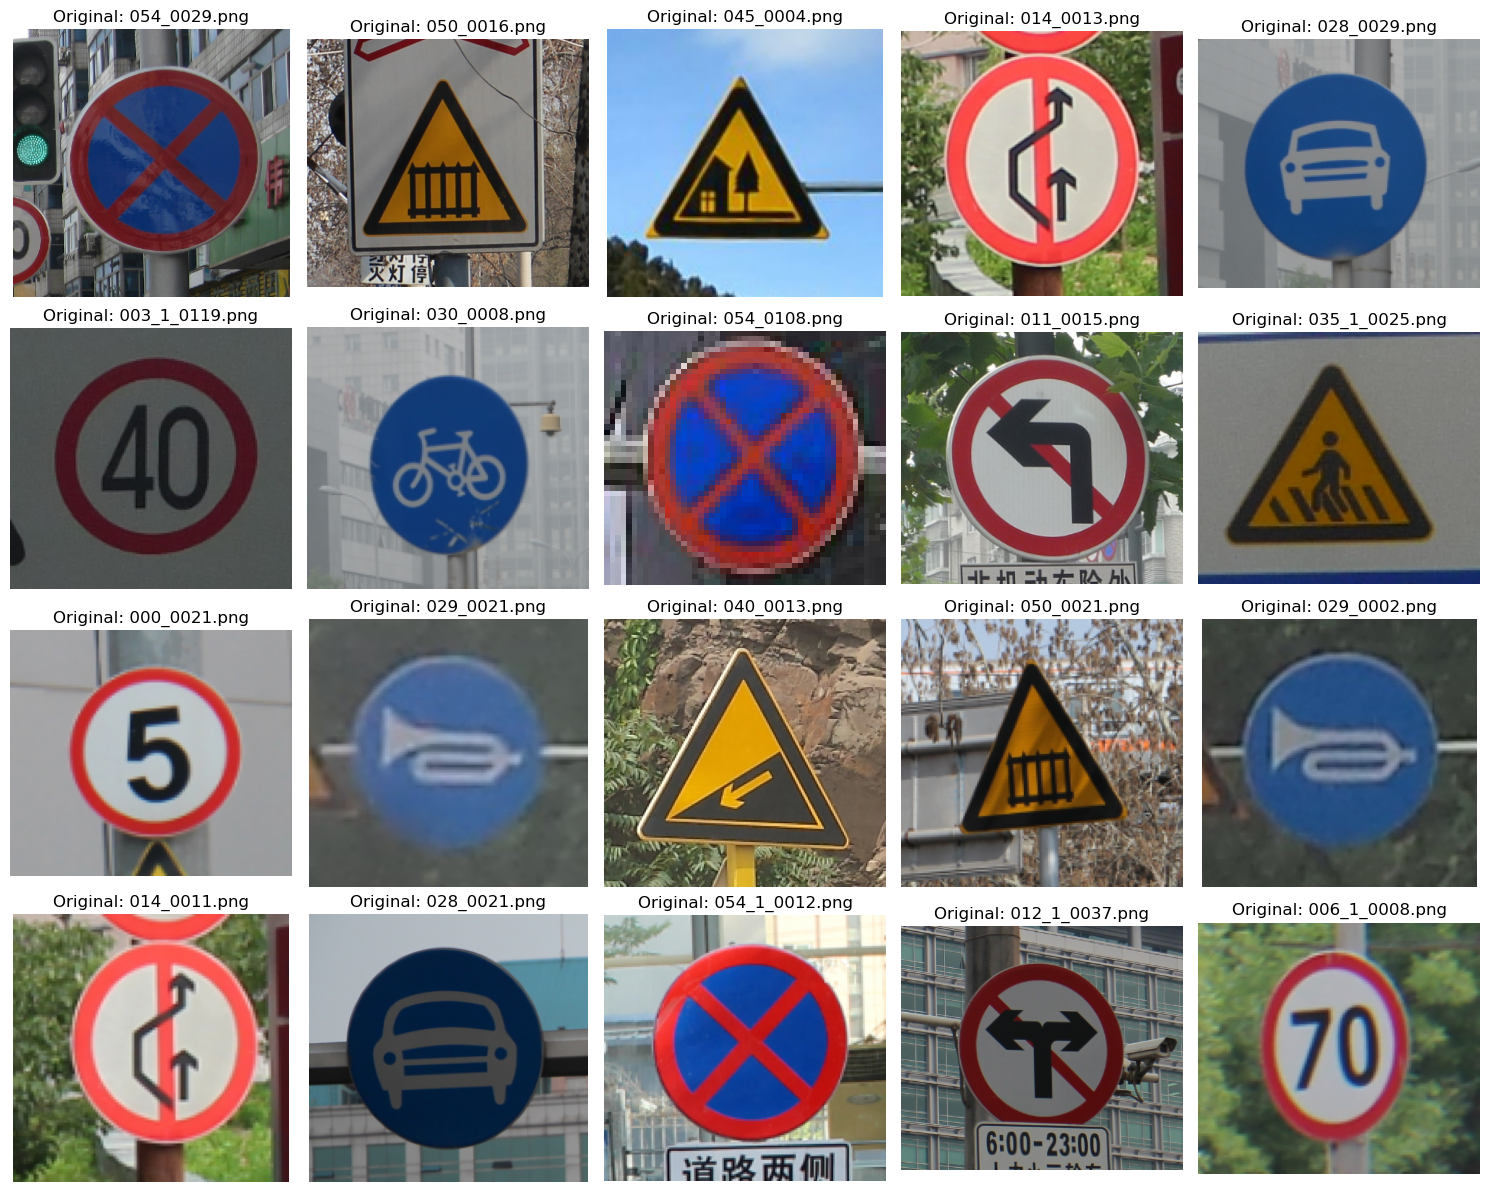

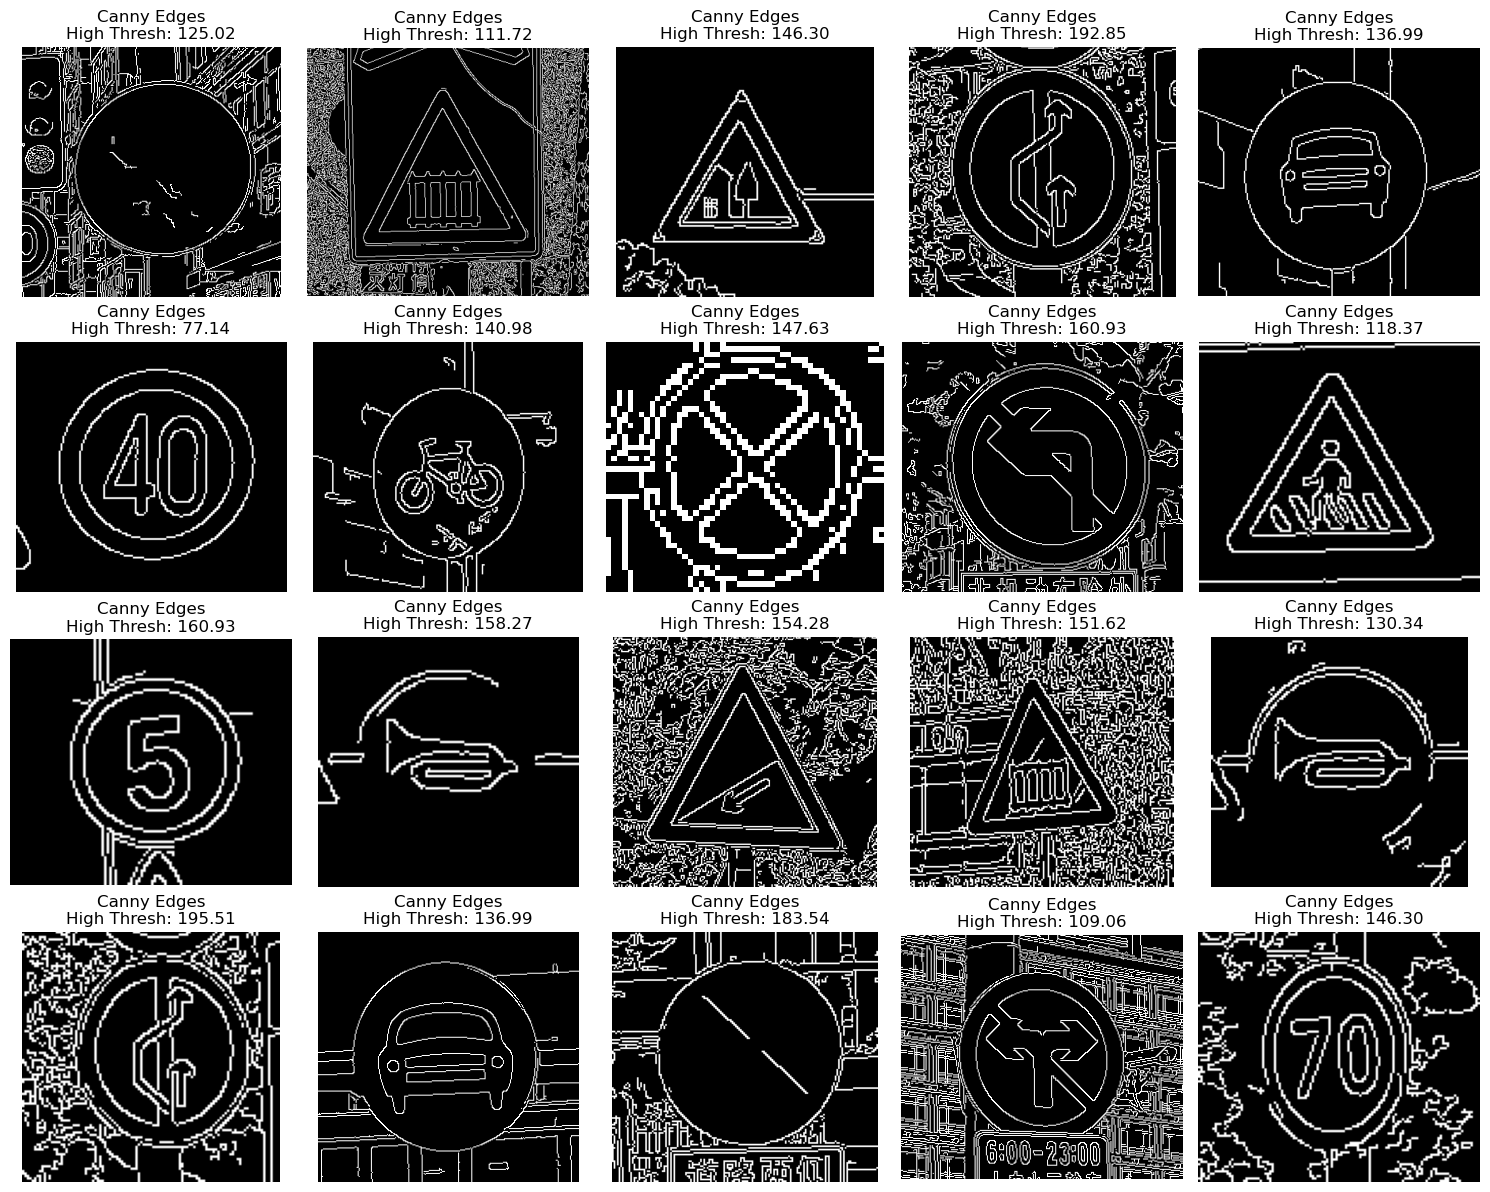

In [21]:
plt.figure(figsize=(15, 12))

for i, img_file in enumerate(files):
    # Read the image
    img = cv.imread(os.path.join(img_dir, img_file))
    
    # Convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    edges, high_threshold = auto_canny(img_gray, method="otsu")  # Change method as needed
    
    # Display original image
    plt.subplot(4, 5, i + 1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(f"Original: {img_file}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 12))
for i, img_file in enumerate(files):
    # Read the image
    img = cv.imread(os.path.join(img_dir, img_file))
    
    # Convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    edges, high_threshold = auto_canny(img_gray, method="otsu")  # Change method as needed

    # Display Canny edge detection result
    plt.subplot(4, 5, i + 1)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Canny Edges\nHigh Thresh: {high_threshold:.2f}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

---
### Traffic Sign Images Processing, Detection and Segmentation

In [22]:
from skimage.exposure import is_low_contrast
from pathlib import Path

img_dir = Path("tsrd-train")

IOUs = []
i = 0
fixed_width = 200
files_no_det = []
img_iou_zero = []
high_img_iou = []
good_segment_img = []
bad_segment_img = []

pix_acc = []
dice_coeff = []
precisions = []
recalls = []
mean_abs_error = []
jaccard_idx = []
hausdorff_dist = []
structural_similarity_index = []

for file in img_dir.glob("*.png"):
    str_fn = str(file)
    img = cv.imread(str_fn)
    if img is None:
        print("No such file exists")
        break
    img_copy = img.copy()
    i += 1
    filename = str_fn.split("\\")[-1]
    
    # Denoise the image + change to grayscale
    img_denoised = cv.medianBlur(img_copy, 3)
    if is_low_contrast(img_denoised):
        img_denoised = contrast_enhance(img_denoised)
        
    # Resize the image
    ratio = fixed_width / img.shape[1]
    img_resized = cv.resize(img_denoised, None, fx=ratio, fy=ratio, interpolation=cv.INTER_AREA)
    
    # change to grayscale
    gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)

    #1: Edge detection + shape detection + combine results of shape detector
    edge, canny_th2 = auto_canny(gray, "otsu")

    # Perform shape detectors
    cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt_edge = cnts[0]
    rect_edge = cnt_rect(cnt_edge)

    hough_circle_parameters["param1"] = canny_th2
    circle_edge = cnt_circle(gray, hough_circle_parameters)
    
    # Detect triangles
    triangle_edge = cnt_triangle(cnt_edge)
    
    # Combine results of shape detectors (rectangle, circle, triangle)
    output1 = integrate_circle_rect_triangle(rect_edge, circle_edge, triangle_edge, cnt_edge)

    # output1 = integrate_circle_rect(rect_edge, circle_edge, cnt_edge)

    # color segmentation
    color_segmented = color_seg(img_resized)

    # perform rectangular object detection
    cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = cnts[0]
    rect = cnt_rect(cnt)

    # perform circular object detection
    hough_circle_parameters["param1"] = 200
    circle = cnt_circle(color_segmented, hough_circle_parameters)
    
    # perform triangle object detection
    triangle = cnt_triangle(cnt)
    
    # Combine results of shape detectors (rectangle, circle, triangle) from color segmentation
    output2 = integrate_circle_rect_triangle(rect, circle, triangle, cnt)

    # output2 = integrate_circle_rect(rect, circle, cnt)
    
    # ground truth bb
    gt_bb = np.array([annotations.loc[filename].x_start, 
                      annotations.loc[filename].y_start,
                      annotations.loc[filename].x_end,
                      annotations.loc[filename].y_end])
    
    gt_bb = (gt_bb*ratio).astype(int)
    
    # create three copies of the img_resized
    img_resized_copy = img_resized.copy()     # good segmented images (IOU >= 0.5)
    img_resized_copy_2 = img_resized.copy()   # failed segmented images (IOU == 0)
    img_resized_copy_3 = img_resized.copy()   # bad segmented images (IOU < 0.5)
    
    # draw rectangle on the three copies of img_resized
    cv.rectangle(img_resized_copy, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)
    cv.rectangle(img_resized_copy_2, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)
    cv.rectangle(img_resized_copy_3, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)
    
    # integrate output1 and output2
    final_output = integrate_edge_color(output1, output2)
    
    # Create a mask for the detected traffic sign
    mask = np.zeros_like(img_resized)
    
    if len(final_output) == 0:
        print("no detection!")
        show_img("no detection", img_resized)
        IOUs.append(0)
        files_no_det.append(str_fn)
        
    else:
        x, y, w, h = cv.boundingRect(final_output)
        
        # bounding the copies of img_resized
        cv.rectangle(img_resized_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)     # good segmented images (IOU >= 0.5)
        cv.rectangle(img_resized_copy_2, (x, y), (x+w, y+h), (0, 255, 0), 2)   # failed segmented images (IOU == 0)
        cv.rectangle(img_resized_copy_3, (x, y), (x+w, y+h), (0, 255, 0), 2)   # bad segmented images (IOU < 0.5)
        
        pred_bb = (x, y, x+w, y+h)

        IOU = computeIOU(gt_bb, pred_bb)
        
        # put text on the copies of img_resized
        cv.putText(img_resized_copy, f"IOU: {IOU:.3f}", (12, 12), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255))
        cv.putText(img_resized_copy_2, f"IOU: {IOU:.3f}", (12, 12), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255))
        cv.putText(img_resized_copy_3, f"IOU: {IOU:.3f}", (12, 12), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255))
        
        IOUs.append(IOU)
        
        # Create a filled polygon based on the detected contours
        cv.fillConvexPoly(mask, final_output, (255, 255, 255))

        # Use the mask to extract the traffic sign from the image
        traffic_sign_only = cv.bitwise_and(img_resized, mask)
        
        if IOU >= 0.5:
            good_segment_img.append(traffic_sign_only)
            high_img_iou.append(img_resized_copy)
        
        elif IOU == 0:
            img_iou_zero.append(img_resized_copy_2)
            if i % 200 == 0:
                show_img(f"IOU: {IOU:.3f}", img_resized_copy_2)
        
        else:
            bad_segment_img.append(img_resized_copy_3)
               
        # Assuming traffic_sign_only is a binary mask of the segmented traffic sign
        # and gt_bb is the ground truth bounding box converted to a binary mask
        # predicted_mask = (traffic_sign_only > 0).astype(np.uint8)  # Convert to binary mask
        # ground_truth_mask = np.zeros_like(img_resized, dtype=np.uint8)
        # cv.rectangle(ground_truth_mask, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), 1, -1)  # Create binary mask for ground truth
        # 
        # # Compute additional metrics
        # accuracy = pixel_accuracy(predicted_mask, ground_truth_mask)
        # pix_acc.append(accuracy)
        # 
        # dice = dice_coefficient(predicted_mask, ground_truth_mask)
        # dice_coeff.append(dice)
        # 
        # precision, recall = precision_recall(predicted_mask, ground_truth_mask)
        # precisions.append(precision)
        # recalls.append(recall)
        # 
        # mae = mean_absolute_error(predicted_mask, ground_truth_mask)
        # mean_abs_error.append(mae)
        # 
        # jaccard = jaccard_index(predicted_mask, ground_truth_mask)
        # jaccard_idx.append(jaccard)
        # 
        # hausdorff = hausdorff_distance(predicted_mask, ground_truth_mask)
        # hausdorff_dist.append(hausdorff)
        # 
        # ssim_value = compute_ssim(predicted_mask, ground_truth_mask)
        # structural_similarity_index.append(ssim_value)

---
### Result Analysis

In [23]:
IOU_series = pd.Series(IOUs)
IOU_series.describe()

count    4170.000000
mean        0.714339
std         0.294625
min         0.000000
25%         0.592581
50%         0.829795
75%         0.939243
max         1.000000
dtype: float64

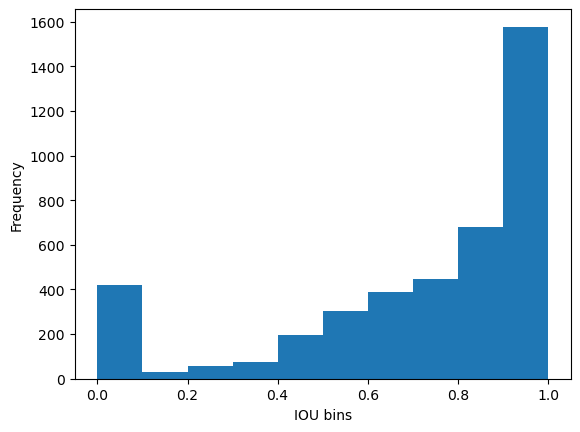

In [24]:
# Histogram
IOU_series.hist()
plt.xlabel("IOU bins"), plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [25]:
len(files_no_det)

0

In [26]:
len(img_iou_zero)  # failed segmented images (IOU == 0)

150

In [27]:
# Count bad segmented images (IOU < 0.5 and IOU != 0)
len(bad_segment_img)

626

In [28]:
arr_IOU = np.array(IOUs)
(arr_IOU>=0.5).sum()   # good segmented images (IOU >= 0.5)

3394

In [29]:
print(f"The proportion of good segmentation: {round((arr_IOU>=0.5).sum() / 4170, 4)}")

The proportion of good segmentation: 0.8139


In [30]:
print(f"Segmentation Accuracy Percentage: {round((arr_IOU>=0.5).sum() / 4170 * 100, 2)}%")

Segmentation Accuracy Percentage: 81.39%


---
### Good Segmented Images

In [31]:
arr_IOU = np.array(IOUs)
(arr_IOU>=0.5).sum()

3394

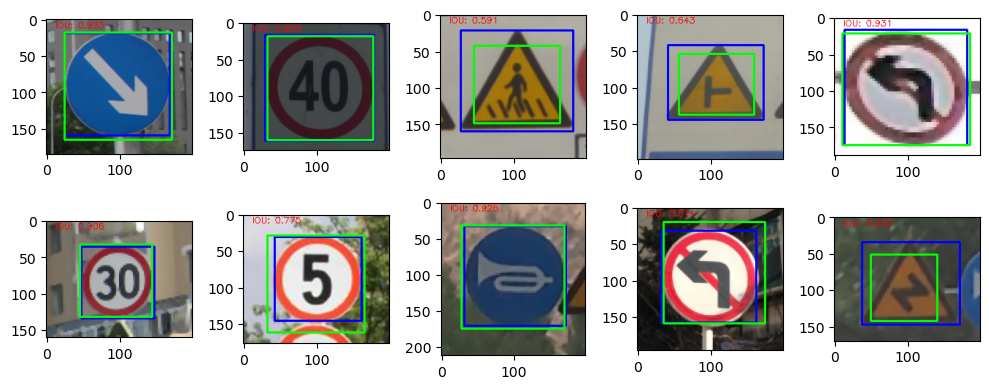

In [32]:
# display images with high IOU (>= 0.5)
import random
idx_images = np.arange(len(high_img_iou))

idx_random_images = np.random.choice(idx_images, 10, replace=False)

fig = plt.figure(figsize=(10, 4))

for i_plot, i_img in enumerate(idx_random_images):
    plt.subplot(2, 5, i_plot+1)
    image = high_img_iou[i_img]
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
plt.tight_layout()
plt.show()

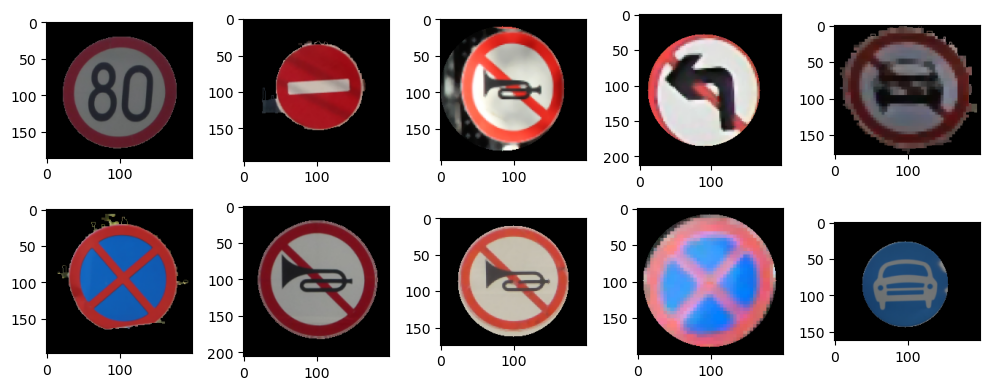

In [33]:
# display good segmented images (IOU >= 0.5)
import random
idx_images = np.arange(len(good_segment_img))

idx_random_images = np.random.choice(idx_images, 10, replace=False)

fig = plt.figure(figsize=(10, 4))

for i_plot, i_img in enumerate(idx_random_images):
    plt.subplot(2, 5, i_plot+1)
    image = good_segment_img[i_img]
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
plt.tight_layout()
plt.show()

---
### Bad Segmented Images

In [34]:
len(bad_segment_img)

626

In [35]:
# Count bad segmented images (IOU < 0.5 and IOU != 0)
bad_segmented_count = (arr_IOU < 0.5) & (arr_IOU != 0)
num_bad_segmented_images = bad_segmented_count.sum()
print(num_bad_segmented_images)

626


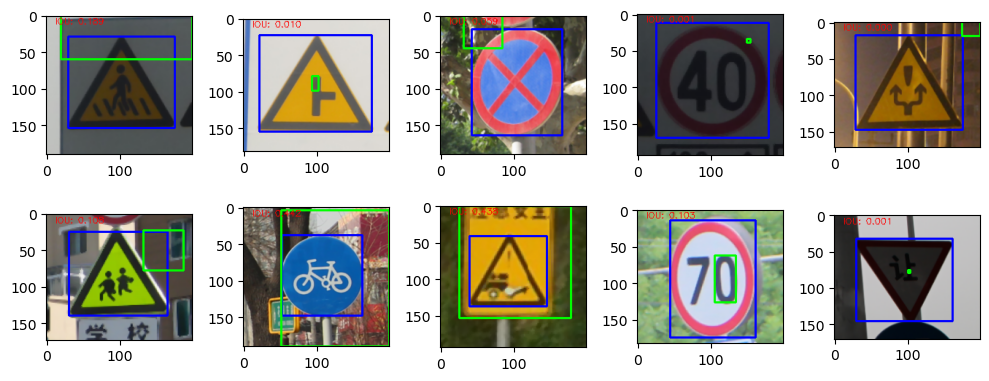

In [36]:
# display images with low IOU (< 0.5 and != 0)
import random
idx_images = np.arange(len(bad_segment_img))

idx_random_images = np.random.choice(idx_images, 10, replace=False)

fig = plt.figure(figsize=(10, 4))

for i_plot, i_img in enumerate(idx_random_images):
    plt.subplot(2, 5, i_plot+1)
    image = bad_segment_img[i_img]
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
plt.tight_layout()
plt.show()

---
### Zero IOU images

In [37]:
len(img_iou_zero)  # total of failed segmented images (IOU == 0)

150

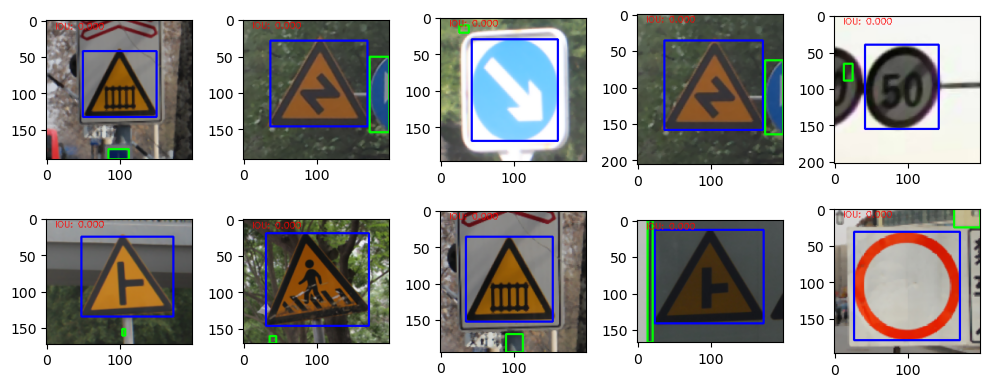

In [38]:
import random
idx_images = np.arange(len(img_iou_zero))

idx_random_images = np.random.choice(idx_images, 10, replace=False)

fig = plt.figure(figsize=(10, 4))

for i_plot, i_img in enumerate(idx_random_images):
    plt.subplot(2, 5, i_plot+1)
    image = img_iou_zero[i_img]
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
plt.tight_layout()
plt.show()

In [39]:
cv.__version__

'4.10.0'